In [473]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
%matplotlib inline
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
from time import gmtime, strftime
from sklearn.preprocessing import StandardScaler

# Model
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from matplotlib import pyplot
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

import toolkit as tool

import os

os.system('date')

ter 19 dez 2023 11:59:31 -03


0

### Objective

The data is for company X which is trying to control attrition. There are two sets of data: “Existing employees” and “Employees who have left”. Following attributes are available for every employee.
 - Satisfaction Level
 - Last evaluation
 - Number of projects
 - Average monthly hours
 - Time spent at the company
 - Whether they have had a work accident
 - Whether they have had a promotion in the last 5 years
 - Departments (column sales)
 - Salary
 - Whether the employee has left

In [474]:
modelname = 'model'

dfmetrics = pd.DataFrame()

def metric_models(modelname, model, X_test, y_test, y_pred, dfmetrics):
    acc   = round(accuracy_score(y_test,y_pred), 4)*100
    score = round(metrics.precision_score(y_test, y_pred, average='macro'), 4)*100
    mae   = round(mean_absolute_error(y_test, y_pred), 5)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    auc = round((metrics.roc_auc_score(y_test, y_pred_proba)), 8)*100

    modelmetrics = {'model': f'{modelname}',
                    'accuracy': acc,
                    'score': score,
                    'mae': mae,
                    'auc': auc   
                   }

    dfmodelmetrics = pd.DataFrame([modelmetrics])
    dfmetrics = pd.concat([dfmetrics if not dfmetrics.empty else None, dfmodelmetrics ], ignore_index=True)

    print(f'{modelname} model:')
    print(f"accuracy........:{acc}%")
    print(f'score...........:{score}')
    print(f"Mean Absolute Error: {mae}")
    print(f"Area under curve (AUC): {auc} %")

    return dfmetrics

In [475]:
def plot_conf_matrix(y_test, y_pred, model_name):
    confusion_matrix1 = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix1).plot()
    plt.title(f"Confusion Matrix: {model_name}")
    plt.grid(False)
    plt.show()

In [476]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_catboostmodel.csv')
df = df.drop(columns=['Emp ID'])
df

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.90,0.55,3,259,10,1,0,1,management,high
14995,0.74,0.95,5,266,10,0,0,1,management,high
14996,0.85,0.54,3,185,10,0,0,1,management,high
14997,0.33,0.65,3,172,10,0,0,1,marketing,high


In [477]:
# define categorial features of dataset
cat_features = ['dept', 'salary']  # List of categorical features

In [478]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover'])
y = df['turnover']

In [479]:
testsize = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testsize, random_state=123, stratify=y, shuffle = True)

In [480]:
cat_model = CatBoostClassifier(
    iterations = 300, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'AUC',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 10,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    cat_features=cat_features,
    bagging_temperature = 0.5,
    thread_count=-1 # number of threads, setted all CPU cores
    #task_type = "GPU",
)

# Train the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
y_pred_cat = cat_model.predict(X_test)

print ("\n\n ---CatBoostClassifier Model---")
cat_roc_auc = roc_auc_score(y_test, y_pred_cat)
print ("CatBoost AUC = %2.4f" % cat_roc_auc)
print(classification_report(y_test, y_pred_cat))



 ---CatBoostClassifier Model---
CatBoost AUC = 0.9864
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [481]:
cat_model.get_params()

{'iterations': 300,
 'learning_rate': 0.1,
 'depth': 10,
 'l2_leaf_reg': 5,
 'loss_function': 'MultiClass',
 'leaf_estimation_iterations': 100,
 'random_strength': 0.5,
 'eval_metric': 'AUC',
 'bagging_temperature': 0.5,
 'bootstrap_type': 'Bayesian',
 'cat_features': ['dept', 'salary']}

In [482]:
dfmetrics = metric_models('CatBoostClassifier', cat_model, X_test, y_test, y_pred_cat, dfmetrics)
dfmetrics

CatBoostClassifier model:
accuracy........:99.1%
score...........:98.88
Mean Absolute Error: 0.009
Area under curve (AUC): 99.489831 %


,model,accuracy,score,mae,auc
0,CatBoostClassifier,99.1,98.88,0.009,99.489831


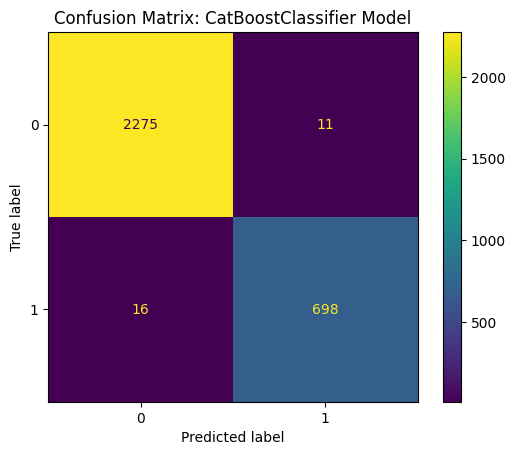

In [483]:
plot_conf_matrix(y_test, y_pred_cat, 'CatBoostClassifier Model')

In [484]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, cat_model.feature_importances_):
    importance = round(importance*100, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: satisfaction, importance: 1920.08 %
2 - feature: evaluation, importance: 1587.28 %
3 - feature: projectCount, importance: 1304.4 %
4 - feature: averageMonthlyHours, importance: 1511.54 %
5 - feature: yearsAtCompany, importance: 1536.76 %
6 - feature: workAccident, importance: 262.4 %
7 - feature: promotion, importance: 11.3 %
8 - feature: dept, importance: 1005.43 %
9 - feature: salary, importance: 860.82 %


In [485]:
list_feat_importances = list(cat_model.feature_importances_)
dict_feat_importances = {}

i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 19.2 %
evaluation.......: 15.87 %
projectCount.......: 13.04 %
averageMonthlyHours.......: 15.12 %
yearsAtCompany.......: 15.37 %
workAccident.......: 2.62 %
promotion.......: 0.11 %
dept.......: 10.05 %
salary.......: 8.61 %


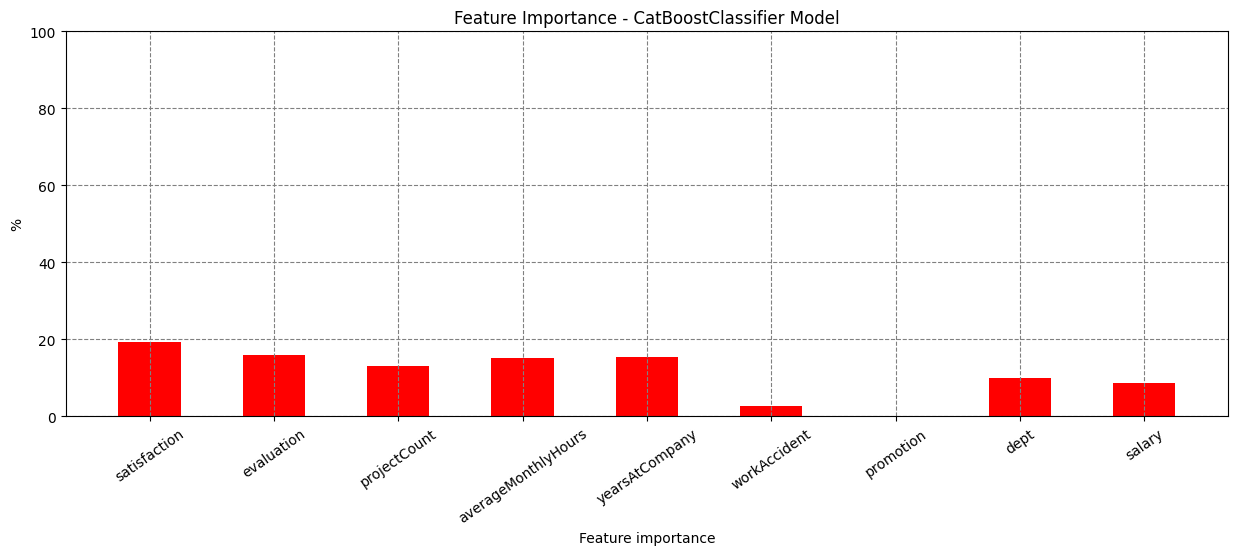

In [486]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - CatBoostClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [487]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df

,Emp ID,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,1,0.38,0.53,2,157,3,0,1,0,7,1
1,2,0.80,0.86,5,262,6,0,1,0,7,2
2,3,0.11,0.88,7,272,4,0,1,0,7,2
3,4,0.72,0.87,5,223,5,0,1,0,7,1
4,5,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...
14994,14207,0.90,0.55,3,259,10,1,0,1,4,0
14995,14208,0.74,0.95,5,266,10,0,0,1,4,0
14996,14209,0.85,0.54,3,185,10,0,0,1,4,0
14997,14210,0.33,0.65,3,172,10,0,0,1,5,0


In [488]:
df.dtypes

Emp ID                   int64
satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
turnover                 int64
promotion                int64
dept                     int64
salary                   int64
dtype: object

In [489]:
print(df['dept'].value_counts(normalize=True).map('{:.2%}'.format))

7    27.60%
9    18.13%
8    14.86%
0     8.18%
6     6.01%
5     5.72%
1     5.25%
2     5.11%
3     4.93%
4     4.20%
Name: dept, dtype: object


In [490]:
shape_rows = df.shape[0]
shape_columns = df.shape[1]

print(f'Dataset rows = {shape_rows} and columns = {shape_columns}.')

Dataset rows = 14999 and columns = 11.


### X and y 

In [491]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover', 'Emp ID'])
y = df['turnover']

In [492]:
# Method of inertia to find the ideal of clusters.
inertia = []
for k in range(1, 11):
    clf = KMeans(n_clusters = k , random_state= 123)
    clf.fit(X)
    inertia.append(clf.inertia_)

In [493]:
pd.DataFrame({"k":list(range(1 , 11)),
              "inércia": inertia})

,k,inércia
0,1,3.759731e+07
1,2,8.982092e+06
2,3,4.520220e+06
3,4,2.909351e+06
4,5,2.096935e+06
5,6,1.567737e+06
6,7,1.256145e+06
7,8,9.821504e+05
8,9,7.868616e+05
9,10,6.740358e+05


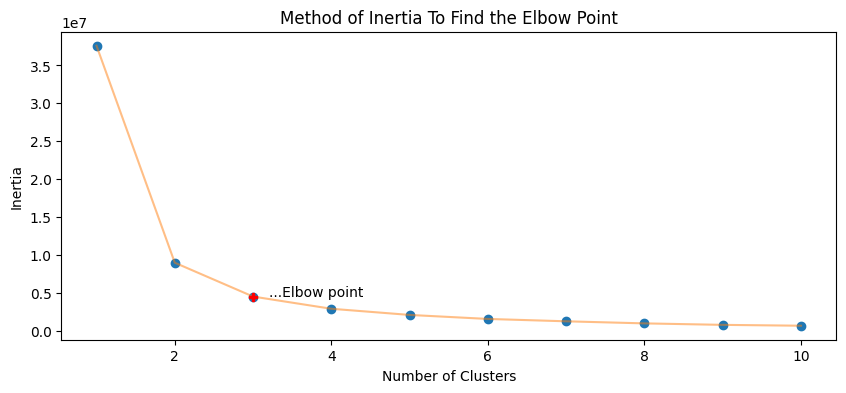

In [494]:
plt.figure(1 , figsize = (10 ,4))
plt.title('Method of Inertia To Find the Elbow Point')
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')

# adicionado depois... ;-)
plt.plot(3 , inertia[2] , 'P', alpha = 1, color = 'red')
plt.text(3 + 0.2 , inertia[2] , '...Elbow point')

plt.show()

In [495]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

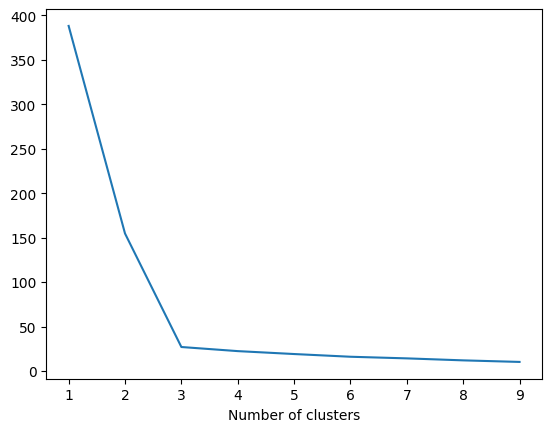

In [496]:
# Determine number of clusters with K-means elbow method
# The arc of the elbow shows that number 3 is our best fit and as thus we would create  3 clusters of employee
sse={}
br = df[df.turnover==1][["satisfaction","evaluation"]]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df[df.turnover==1][["satisfaction","evaluation"]])

    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [497]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=df["satisfaction"], y=df["evaluation"],
    mode='markers',
    marker=dict(
        color= kmeans_colors,
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100],
    )
)])
fig.update_layout(title_text='Employee Cluster Chart')
fig.show()

### Train and Test features

In [498]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df = df.drop(columns=['Emp ID'])
df

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,0.38,0.53,2,157,3,0,1,0,7,1
1,0.80,0.86,5,262,6,0,1,0,7,2
2,0.11,0.88,7,272,4,0,1,0,7,2
3,0.72,0.87,5,223,5,0,1,0,7,1
4,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.90,0.55,3,259,10,1,0,1,4,0
14995,0.74,0.95,5,266,10,0,0,1,4,0
14996,0.85,0.54,3,185,10,0,0,1,4,0
14997,0.33,0.65,3,172,10,0,0,1,5,0


In [499]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover'])
y = df['turnover']

In [500]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testsize, random_state=123, stratify=y, shuffle = True)

### Modeling

#### Logistic Regression V.S. Random Forest V.S. Decision Tree V.S. AdaBoost Model


In [501]:
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_train, y_train)

# predict the results
y_pred_lgb=lgb_model.predict(X_test)

print ("\n\n ---LGBMClassifier Model---")
lgb_roc_auc = roc_auc_score(y_test, y_pred_lgb)
print ("LGBMClassifier AUC = %2.2f" % lgb_roc_auc)
print(classification_report(y_test, y_pred_lgb))



 ---LGBMClassifier Model---
LGBMClassifier AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.96      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [502]:
lgb_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [503]:
dfmetrics = metric_models('LightGBMClassifier', lgb_model, X_test, y_test, y_pred_lgb, dfmetrics)
dfmetrics

LightGBMClassifier model:
accuracy........:98.6%
score...........:98.34
Mean Absolute Error: 0.014
Area under curve (AUC): 99.547452 %


,model,accuracy,score,mae,auc
0,CatBoostClassifier,99.1,98.88,0.009,99.489831
1,LightGBMClassifier,98.6,98.34,0.014,99.547452


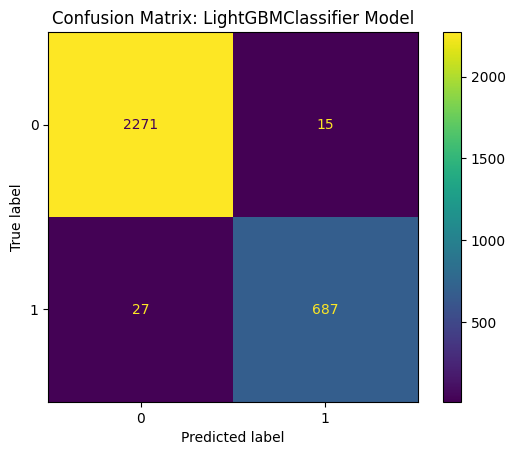

In [504]:
plot_conf_matrix(y_test, y_pred_lgb, 'LightGBMClassifier Model')

In [505]:
# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced",
    n_jobs=-1
    #min_weight_fraction_leaf=0.02 
    )
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, y_pred_rf))



 ---Random Forest Model---
Random Forest AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [506]:
dfmetrics = metric_models('Random Forest', rf_model, X_test, y_test, y_pred_rf, dfmetrics)
dfmetrics

Random Forest model:
accuracy........:98.87%
score...........:98.96000000000001
Mean Absolute Error: 0.01133
Area under curve (AUC): 99.43689599999999 %


,model,accuracy,score,mae,auc
0,CatBoostClassifier,99.10,98.88,0.00900,99.489831
1,LightGBMClassifier,98.60,98.34,0.01400,99.547452
2,Random Forest,98.87,98.96,0.01133,99.436896


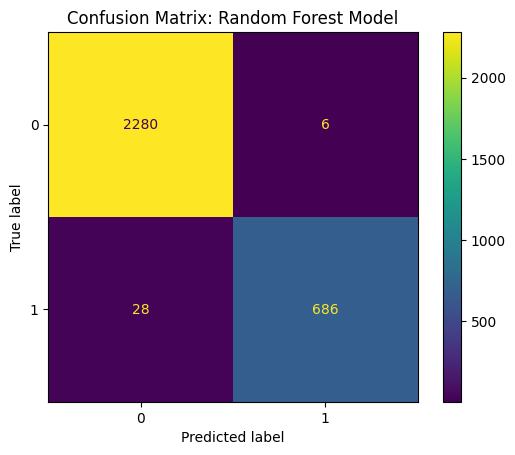

In [507]:
plot_conf_matrix(y_test, y_pred_rf, 'Random Forest Model')

In [508]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, rf_model.feature_importances_):
    importance = round(importance*100, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: satisfaction, importance: 28.89 %
2 - feature: evaluation, importance: 12.84 %
3 - feature: projectCount, importance: 15.48 %
4 - feature: averageMonthlyHours, importance: 14.92 %
5 - feature: yearsAtCompany, importance: 25.31 %
6 - feature: workAccident, importance: 0.69 %
7 - feature: promotion, importance: 0.12 %
8 - feature: dept, importance: 1.1 %
9 - feature: salary, importance: 0.63 %


In [509]:
list_feat_importances = list(rf_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 28.89 %
evaluation.......: 12.84 %
projectCount.......: 15.48 %
averageMonthlyHours.......: 14.92 %
yearsAtCompany.......: 25.31 %
workAccident.......: 0.69 %
promotion.......: 0.12 %
dept.......: 1.1 %
salary.......: 0.63 %


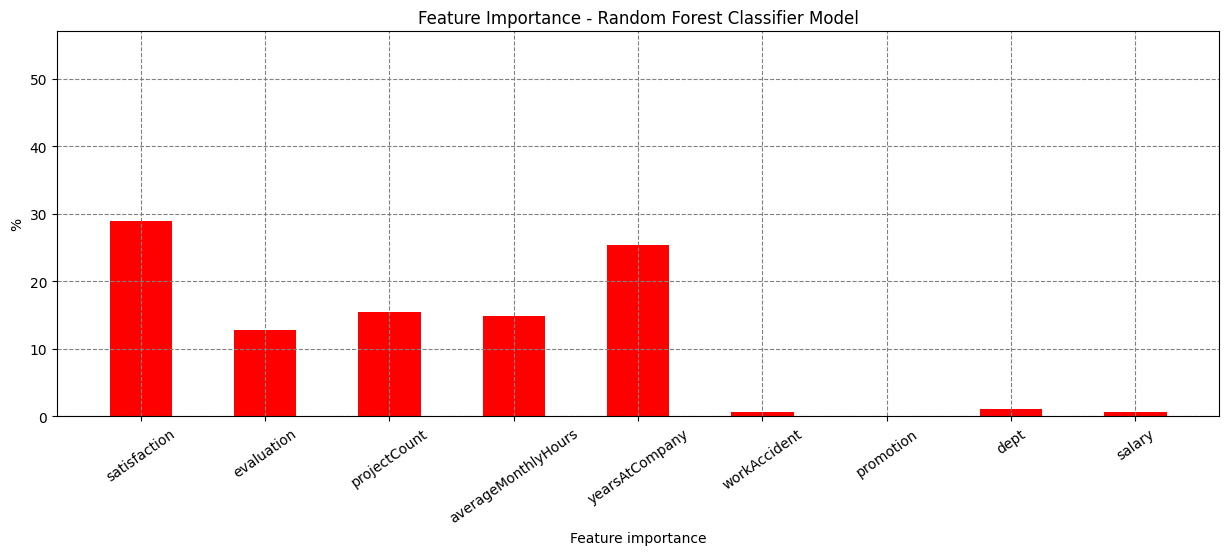

In [510]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,57)
plt.title("Feature Importance - Random Forest Classifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [511]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print ("\n\n ---XGBClassifier Model---")
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
print ("XGBClassifier AUC = %2.2f" % xgb_roc_auc)
print(classification_report(y_test, y_pred_xgb))



 ---XGBClassifier Model---
XGBClassifier AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [512]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [513]:
dfmetrics = metric_models('XGBClassifier', xgb_model, X_test, y_test, y_pred_xgb, dfmetrics)
dfmetrics

XGBClassifier model:
accuracy........:98.87%
score...........:98.53
Mean Absolute Error: 0.01133
Area under curve (AUC): 99.549934 %


,model,accuracy,score,mae,auc
0,CatBoostClassifier,99.10,98.88,0.00900,99.489831
1,LightGBMClassifier,98.60,98.34,0.01400,99.547452
2,Random Forest,98.87,98.96,0.01133,99.436896
3,XGBClassifier,98.87,98.53,0.01133,99.549934


In [514]:
# Create a bar chart
fig = px.histogram(dfmetrics, x="model", y = "accuracy", color="model")
fig.update_layout(title_text='Accuracy for models',xaxis_title="model",
    yaxis_title="Accuracy (%)", yaxis_range=[98,100])
fig.show()

In [515]:
# Create a bar chart
fig = px.histogram(dfmetrics, x="model", y = "score", color="model")
fig.update_layout(title_text='Score for models',xaxis_title="model",
    yaxis_title="Score (%)", yaxis_range=[98,100])
fig.show()

In [516]:
# Create a bar chart
fig = px.histogram(dfmetrics, x="model", y = "mae", color="model")
fig.update_layout(title_text='Mean Absolute Error (MAE) for models',xaxis_title="model",
    yaxis_title="MAE")
fig.show()

In [517]:
# Create a bar chart
fig = px.histogram(dfmetrics, x="model", y = "auc", color="model")
fig.update_layout(title_text='Area Under the Curve for models',xaxis_title="model",
    yaxis_title="AUC (%)", yaxis_range=[99,100])
fig.show()

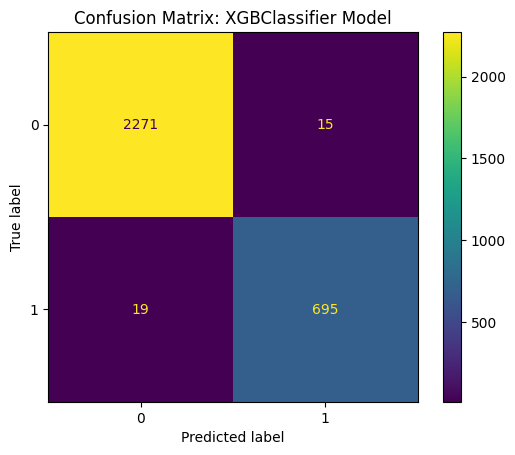

In [518]:
plot_conf_matrix(y_test, y_pred_xgb, 'XGBClassifier Model')

In [519]:
list_feat_importances = list(xgb_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i]*100 # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 31.07 %
evaluation.......: 10.29 %
projectCount.......: 16.48 %
averageMonthlyHours.......: 5.19 %
yearsAtCompany.......: 24.55 %
workAccident.......: 6.2 %
promotion.......: 1.68 %
dept.......: 1.83 %
salary.......: 2.71 %


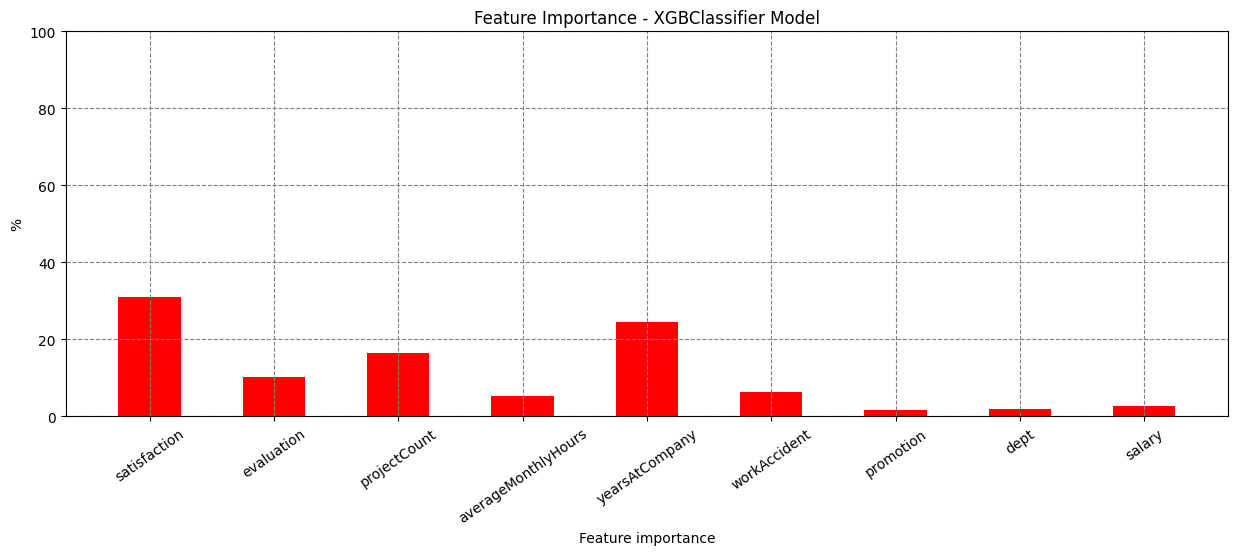

In [520]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - XGBClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

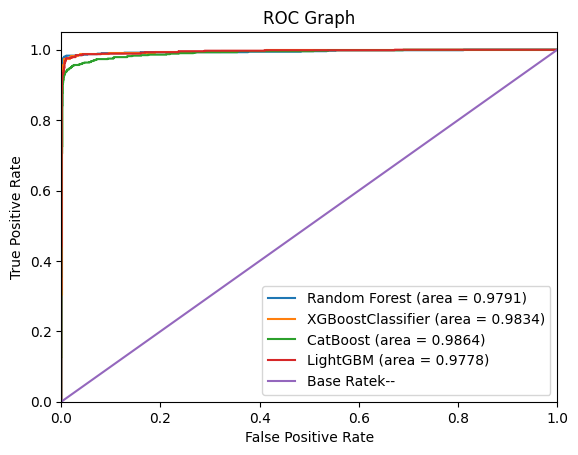

In [521]:
# Create ROC Graph
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
cat_fpr, cat_tpr, cat_thresholds = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1])
lgb_fpr, lgb_tpr, lgb_thresholds = roc_curve(y_test, lgb_model.predict_proba(X_test)[:,1])

plt.figure()

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.4f)' % rf_roc_auc)

# Plot XGBoostClassifier ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGBoostClassifier (area = %0.4f)' % xgb_roc_auc)

# Plot XGBoostClassifier ROC
plt.plot(cat_fpr, cat_tpr, label='CatBoost (area = %0.4f)' % cat_roc_auc)

# Plot LightGBM ROC
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM (area = %0.4f)' % lgb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

# Save the plot as a PNG file
plt.savefig('../images/roc_curve_bestmodels.png')

plt.show()

In [522]:
os.system('date')

ter 19 dez 2023 12:01:53 -03


0